# Double descent with Random Fourier Features

In [14]:
import numpy as np
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import zero_one_loss, mean_squared_error, log_loss
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import svd

In [15]:
def generate_gaussian_parity(n, cov_scale=1, angle_params=None, k=1, seed=None):
    np.random.seed(seed)
#     means = [[-1.5, -1.5], [1.5, 1.5], [1.5, -1.5], [-1.5, 1.5]]
    means = [[-1, -1], [1, 1], [1, -1], [-1, 1]]
    blob = np.concatenate(
        [
            np.random.multivariate_normal(
                mean, cov_scale * np.eye(len(mean)), size=int(n / 4)
            )
            for mean in means
        ]
    )

    Y = np.concatenate([np.ones((int(n / 4))) * int(i < 2) for i in range(len(means))])
    if angle_params is not None:
        X = np.zeros_like(blob)
        X[:, 0] = blob[:, 0] * np.cos(angle_params * np.pi / 180) + blob[:, 1] * np.sin(
            angle_params * np.pi / 180
        )
        X[:, 1] = -blob[:, 0] * np.sin(angle_params * np.pi / 180) + blob[:, 1] * np.cos(
            angle_params * np.pi / 180
        )
    else:
        X = blob
    return X, Y.astype(int)

class RFFTransformer:
    def __init__(self, d, sigma=1, seed=None, relu=False):
        self.d = d
        self.sigma = sigma
        self.seed = seed
        self.relu = relu
    
    def fit(self, X):
        np.random.seed(self.seed)
        self.w = np.random.normal(0, self.sigma, (X.shape[1], self.d))
        self.b = np.random.uniform(0, 2*np.pi, (self.d,))
        return self

    def transform(self, X):
        rff = np.cos(X @ self.w + self.b)
        if self.relu:
            rff = np.maximum(rff, 0)
        return rff

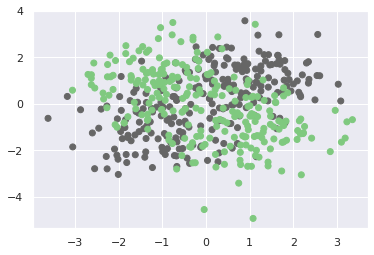

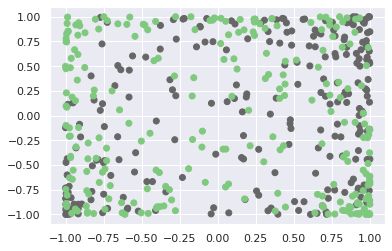

In [16]:
X, y = generate_gaussian_parity(500)#, angle_params=0)
plt.scatter(*X.T, c=y, cmap='Accent')
plt.show()
plt.scatter(*RFFTransformer(2).fit(X).transform(X).T, c=y, cmap='Accent')
plt.show()

In [66]:
# # ds = [2, 5, 10, 25, 50, 100, 500, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1500, 2000]
# 
# # ds = [2, 5, 10, 50, 100, 500] + list(np.arange(850, 1200, 10)) + [1500, 2000]
# ds = np.asarray(list(np.logspace(0, np.log10(20), 15)) + [30, 60, 100, 200]) * 1e2
# ds = np.append(ds, [n, 1, 5])
# ds = ds.astype(int)

n = 100
fall = np.logspace(np.log10(n), np.log10(1.5*n), 5).astype(int)
rise = -np.logspace(np.log10(n), np.log10(1.5*n), 5).astype(int) + 2*n
start = np.logspace(0, np.log10(0.5 * n), 10).astype(int)
ds = np.unique(np.concatenate([start, rise, fall, [5*n, 10*n, 25*n]]))

df_mat = []

n_reps = 10
X_test_full, y_test = generate_gaussian_parity(10000, seed=n_reps+1)

for i in range(n_reps):
    X_train, y_train = generate_gaussian_parity(n)
    rff = RFFTransformer(max(ds), relu=True).fit(X_train)
    X_train = rff.transform(X_train)
    X_test = rff.transform(X_test_full)
        
    for p in ds:
        # _, singular_values, _ = svd(X_train[:, :p])
        unique_vals, unique_idx = np.unique((X_train[:, :p] > 0).astype(int), axis=0, return_inverse=True)
        internal_rep_mat = np.zeros((len(unique_idx), len(unique_vals)))
        internal_rep_mat[np.arange(len(unique_idx)), unique_idx] = 1
        _, singular_values, _ = svd(internal_rep_mat)

        singular_values = np.sort(singular_values)[::-1]
        s = np.sort(singular_values**2)[::-1]
        max_eval = s[0]
        sum_eval = np.sum(s)
        kf_norms = [np.sum(singular_values[:i+1]) for i in range(10)]
        schatten_norms = [np.sum(singular_values**i)**(1/i) for i in range(1,10+1)]
        
        lr = LogisticRegression(penalty='none', n_jobs=5)
        metric = zero_one_loss # log_loss#  
        # lr = LinearRegression(n_jobs=-2)
        # metric = mean_squared_error

        lr = lr.fit(X_train[:, :p], y_train)
        coef_norm = np.linalg.norm(lr.coef_, axis=1).mean()
        train_error = metric(y_train, lr.predict(X_train[:, :p]))
        test_error = metric(y_test, lr.predict(X_test[:, :p]))

        df_mat.append([p, train_error, test_error, max_eval, sum_eval, coef_norm] + kf_norms + schatten_norms)

### Relu o RFF o XOR (01 error)

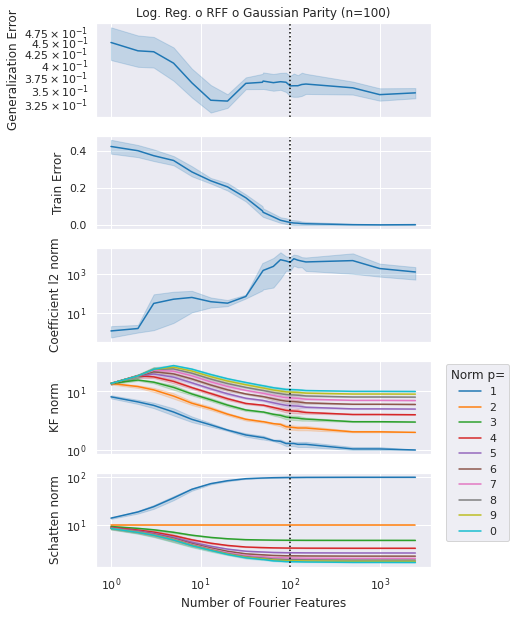

In [67]:
df = pd.DataFrame(
    df_mat,
    columns=[
        'Number of Fourier Features',
        'Train Error',
        'Generalization Error',
        'Max eigenvalue',
        'Sum of eigenvalues',
        'Coefficient l2 norm',
    ] + [f'KF {i+1}' for i in range(10)] + [f'Schatten {i+1}' for i in range(10)]
)#.melt(var_name='Number of Fourier Features', value_name='Generalization Error')
df['Max/sum eigenvalues'] = df['Max eigenvalue'] / df['Sum of eigenvalues']

sns.set_style('darkgrid')
sns.set_context('notebook')

metrics = ['Generalization Error', 'Train Error', 'Coefficient l2 norm']
f, axes = plt.subplots(len(metrics)+2, 1, figsize=(6, 2*len(metrics)+4), sharex=True)
for ax, y_label in zip(axes, metrics):
    sns.lineplot(data=df, x='Number of Fourier Features', y=y_label, ax=ax)
    ax.axvline(n, ls=':', c='black')
    # ax.set_yscale('log')
    
ax = axes[-2]
for metric in [f'KF {i+1}' for i in range(10)]:
    sns.lineplot(data=df, x='Number of Fourier Features', y=metric, ax=ax, label=metric[-1])
ax.set_yscale('log')
ax.set_ylabel('KF norm')
ax.legend(loc='upper left', bbox_to_anchor=(1.03, 1.02), title='Norm p=')
ax.axvline(n, ls=':', c='black')

ax = axes[-1]
for metric in [f'Schatten {i+1}' for i in range(10)]:
    sns.lineplot(data=df, x='Number of Fourier Features', y=metric, ax=ax)#, label=metric[-1])
ax.set_ylabel('Schatten norm')
ax.set_yscale('log')
# ax.legend(loc='upper left', bbox_to_anchor=(1.03, 1.02))
ax.axvline(n, ls=':', c='black')

axes[0].set_yscale('log')
axes[2].set_yscale('log')
axes[-1].set_xscale('log')
# ax.figure.legend()
axes[0].set_title(f'Log. Reg. o RFF o Gaussian Parity (n={n})')

# plt.tight_layout()
# plt.savefig('./figures/ols_vs_ridge_double_descent.pdf')
plt.show()

### Relu o RFF o XOR (Log loss error)

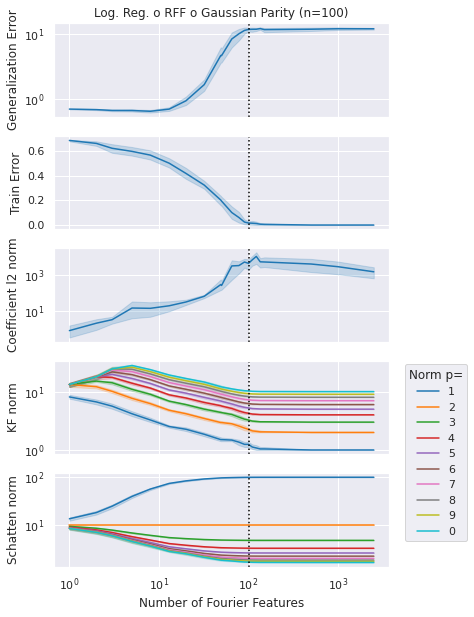

In [65]:
df = pd.DataFrame(
    df_mat,
    columns=[
        'Number of Fourier Features',
        'Train Error',
        'Generalization Error',
        'Max eigenvalue',
        'Sum of eigenvalues',
        'Coefficient l2 norm',
    ] + [f'KF {i+1}' for i in range(10)] + [f'Schatten {i+1}' for i in range(10)]
)#.melt(var_name='Number of Fourier Features', value_name='Generalization Error')
df['Max/sum eigenvalues'] = df['Max eigenvalue'] / df['Sum of eigenvalues']

sns.set_style('darkgrid')
sns.set_context('notebook')

metrics = ['Generalization Error', 'Train Error', 'Coefficient l2 norm']
f, axes = plt.subplots(len(metrics)+2, 1, figsize=(6, 2*len(metrics)+4), sharex=True)
for ax, y_label in zip(axes, metrics):
    sns.lineplot(data=df, x='Number of Fourier Features', y=y_label, ax=ax)
    ax.axvline(n, ls=':', c='black')
    # ax.set_yscale('log')
    
ax = axes[-2]
for metric in [f'KF {i+1}' for i in range(10)]:
    sns.lineplot(data=df, x='Number of Fourier Features', y=metric, ax=ax, label=metric[-1])
ax.set_yscale('log')
ax.set_ylabel('KF norm')
ax.legend(loc='upper left', bbox_to_anchor=(1.03, 1.02), title='Norm p=')
ax.axvline(n, ls=':', c='black')

ax = axes[-1]
for metric in [f'Schatten {i+1}' for i in range(10)]:
    sns.lineplot(data=df, x='Number of Fourier Features', y=metric, ax=ax)#, label=metric[-1])
ax.set_ylabel('Schatten norm')
ax.set_yscale('log')
# ax.legend(loc='upper left', bbox_to_anchor=(1.03, 1.02))
ax.axvline(n, ls=':', c='black')

axes[0].set_yscale('log')
axes[2].set_yscale('log')
axes[-1].set_xscale('log')
# ax.figure.legend()
axes[0].set_title(f'Log. Reg. o RFF o Gaussian Parity (n={n})')

# plt.tight_layout()
# plt.savefig('./figures/ols_vs_ridge_double_descent.pdf')
plt.show()

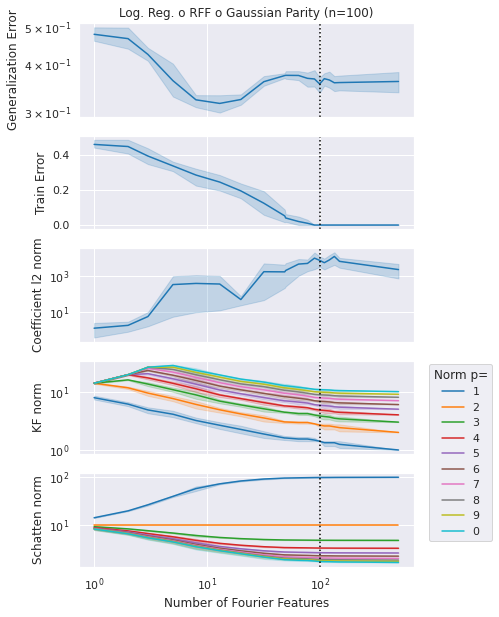

In [61]:
df = pd.DataFrame(
    df_mat,
    columns=[
        'Number of Fourier Features',
        'Train Error',
        'Generalization Error',
        'Max eigenvalue',
        'Sum of eigenvalues',
        'Coefficient l2 norm',
    ] + [f'KF {i+1}' for i in range(10)] + [f'Schatten {i+1}' for i in range(10)]
)#.melt(var_name='Number of Fourier Features', value_name='Generalization Error')
df['Max/sum eigenvalues'] = df['Max eigenvalue'] / df['Sum of eigenvalues']

sns.set_style('darkgrid')
sns.set_context('notebook')

metrics = ['Generalization Error', 'Train Error', 'Coefficient l2 norm']
f, axes = plt.subplots(len(metrics)+2, 1, figsize=(6, 2*len(metrics)+4), sharex=True)
for ax, y_label in zip(axes, metrics):
    sns.lineplot(data=df, x='Number of Fourier Features', y=y_label, ax=ax)
    ax.axvline(n, ls=':', c='black')
    # ax.set_yscale('log')
    
ax = axes[-2]
for metric in [f'KF {i+1}' for i in range(10)]:
    sns.lineplot(data=df, x='Number of Fourier Features', y=metric, ax=ax, label=metric[-1])
ax.set_yscale('log')
ax.set_ylabel('KF norm')
ax.legend(loc='upper left', bbox_to_anchor=(1.03, 1.02), title='Norm p=')
ax.axvline(n, ls=':', c='black')

ax = axes[-1]
for metric in [f'Schatten {i+1}' for i in range(10)]:
    sns.lineplot(data=df, x='Number of Fourier Features', y=metric, ax=ax)#, label=metric[-1])
ax.set_ylabel('Schatten norm')
ax.set_yscale('log')
# ax.legend(loc='upper left', bbox_to_anchor=(1.03, 1.02))
ax.axvline(n, ls=':', c='black')

axes[0].set_yscale('log')
axes[2].set_yscale('log')
axes[-1].set_xscale('log')
# ax.figure.legend()
axes[0].set_title(f'Log. Reg. o RFF o Gaussian Parity (n={n})')

# plt.tight_layout()
# plt.savefig('./figures/ols_vs_ridge_double_descent.pdf')
plt.show()

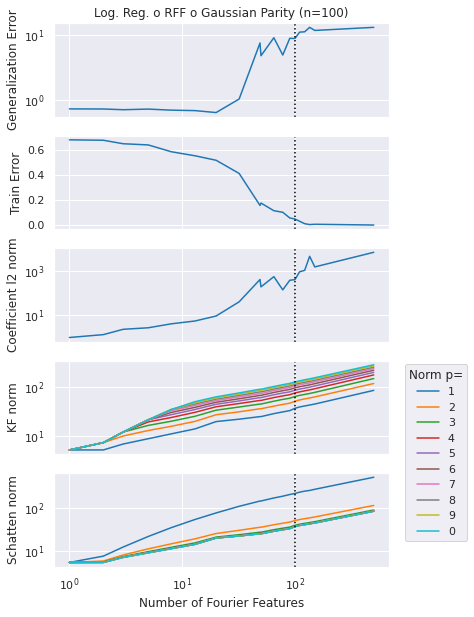

In [48]:
df = pd.DataFrame(
    df_mat,
    columns=[
        'Number of Fourier Features',
        'Train Error',
        'Generalization Error',
        'Max eigenvalue',
        'Sum of eigenvalues',
        'Coefficient l2 norm',
    ] + [f'KF {i+1}' for i in range(10)] + [f'Schatten {i+1}' for i in range(10)]
)#.melt(var_name='Number of Fourier Features', value_name='Generalization Error')
df['Max/sum eigenvalues'] = df['Max eigenvalue'] / df['Sum of eigenvalues']

sns.set_style('darkgrid')
sns.set_context('notebook')

metrics = ['Generalization Error', 'Train Error', 'Coefficient l2 norm']
f, axes = plt.subplots(len(metrics)+2, 1, figsize=(6, 2*len(metrics)+4), sharex=True)
for ax, y_label in zip(axes, metrics):
    sns.lineplot(data=df, x='Number of Fourier Features', y=y_label, ax=ax, ci=None)
    ax.axvline(n, ls=':', c='black')
    # ax.set_yscale('log')
    
ax = axes[-2]
for metric in [f'KF {i+1}' for i in range(10)]:
    sns.lineplot(data=df, x='Number of Fourier Features', y=metric, ax=ax, ci=None, label=metric[-1])
ax.set_yscale('log')
ax.set_ylabel('KF norm')
ax.legend(loc='upper left', bbox_to_anchor=(1.03, 1.02), title='Norm p=')
ax.axvline(n, ls=':', c='black')

ax = axes[-1]
for metric in [f'Schatten {i+1}' for i in range(10)]:
    sns.lineplot(data=df, x='Number of Fourier Features', y=metric, ax=ax)#, ci=None, label=metric[-1])
ax.set_ylabel('Schatten norm')
ax.set_yscale('log')
# ax.legend(loc='upper left', bbox_to_anchor=(1.03, 1.02))
ax.axvline(n, ls=':', c='black')

axes[0].set_yscale('log')
axes[2].set_yscale('log')
axes[-1].set_xscale('log')
# ax.figure.legend()
axes[0].set_title(f'Log. Reg. o RFF o Gaussian Parity (n={n})')

# plt.tight_layout()
# plt.savefig('./figures/ols_vs_ridge_double_descent.pdf')
plt.show()

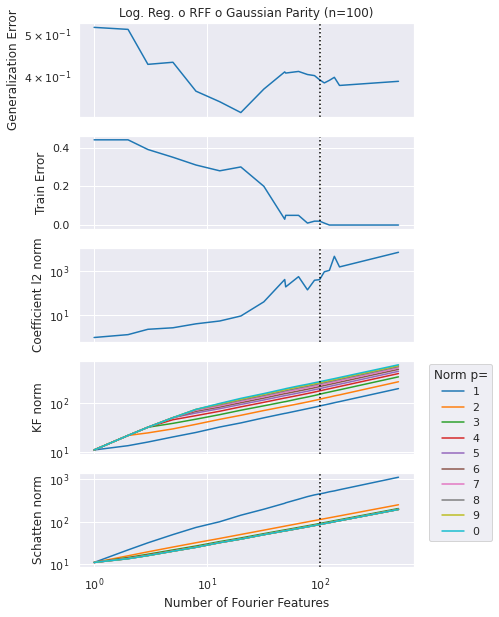

In [25]:
df = pd.DataFrame(
    df_mat,
    columns=[
        'Number of Fourier Features',
        'Train Error',
        'Generalization Error',
        'Max eigenvalue',
        'Sum of eigenvalues',
        'Coefficient l2 norm',
    ] + [f'KF {i+1}' for i in range(10)] + [f'Schatten {i+1}' for i in range(10)]
)#.melt(var_name='Number of Fourier Features', value_name='Generalization Error')
df['Max/sum eigenvalues'] = df['Max eigenvalue'] / df['Sum of eigenvalues']

sns.set_style('darkgrid')
sns.set_context('notebook')

metrics = ['Generalization Error', 'Train Error', 'Coefficient l2 norm']
f, axes = plt.subplots(len(metrics)+2, 1, figsize=(6, 2*len(metrics)+4), sharex=True)
for ax, y_label in zip(axes, metrics):
    sns.lineplot(data=df, x='Number of Fourier Features', y=y_label, ax=ax, ci=None)
    ax.axvline(n, ls=':', c='black')
    # ax.set_yscale('log')
    
ax = axes[-2]
for metric in [f'KF {i+1}' for i in range(10)]:
    sns.lineplot(data=df, x='Number of Fourier Features', y=metric, ax=ax, ci=None, label=metric[-1])
ax.set_yscale('log')
ax.set_ylabel('KF norm')
ax.legend(loc='upper left', bbox_to_anchor=(1.03, 1.02), title='Norm p=')
ax.axvline(n, ls=':', c='black')

ax = axes[-1]
for metric in [f'Schatten {i+1}' for i in range(10)]:
    sns.lineplot(data=df, x='Number of Fourier Features', y=metric, ax=ax)#, ci=None, label=metric[-1])
ax.set_ylabel('Schatten norm')
ax.set_yscale('log')
# ax.legend(loc='upper left', bbox_to_anchor=(1.03, 1.02))
ax.axvline(n, ls=':', c='black')

axes[0].set_yscale('log')
axes[2].set_yscale('log')
axes[-1].set_xscale('log')
# ax.figure.legend()
axes[0].set_title(f'Log. Reg. o RFF o Gaussian Parity (n={n})')

# plt.tight_layout()
# plt.savefig('./figures/ols_vs_ridge_double_descent.pdf')
plt.show()

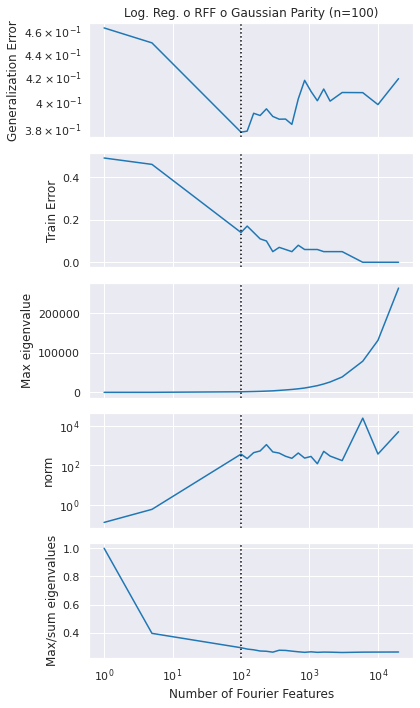

In [4]:
df = pd.DataFrame(
    df_mat,
    columns=[
        'Number of Fourier Features',
        'Train Error',
        'Generalization Error',
        'Max eigenvalue',
        'Sum of eigenvalues',
        'norm',
    ]
)#.melt(var_name='Number of Fourier Features', value_name='Generalization Error')
df['Max/sum eigenvalues'] = df['Max eigenvalue'] / df['Sum of eigenvalues']

sns.set_style('darkgrid')
sns.set_context('notebook')

metrics = ['Generalization Error', 'Train Error', 'Max eigenvalue', 'norm', 'Max/sum eigenvalues']
f, axes = plt.subplots(len(metrics), 1, figsize=(6, 2*len(metrics)), sharex=True)
for ax, y_label in zip(axes, metrics):
    sns.lineplot(data=df, x='Number of Fourier Features', y=y_label, ax=ax)#, ci=None)
    ax.axvline(n, ls=':', c='black')

axes[0].set_yscale('log')
axes[3].set_yscale('log')
axes[-1].set_xscale('log')
# ax.figure.legend()
axes[0].set_title(f'Log. Reg. o RFF o Gaussian Parity (n={n})')

plt.tight_layout()
# plt.savefig('./figures/ols_vs_ridge_double_descent.pdf')
plt.show()

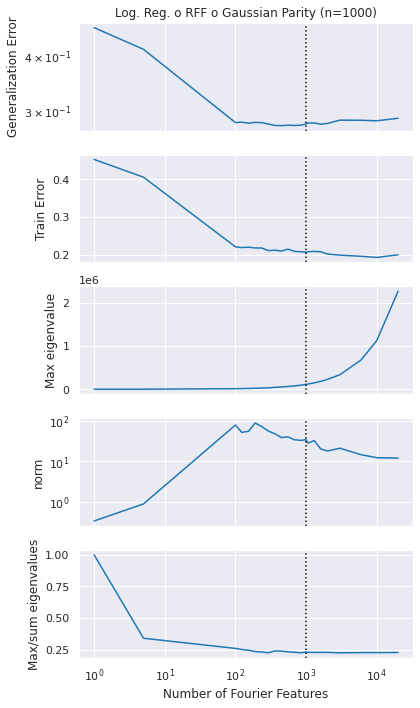

In [60]:
sns.set_style('darkgrid')
sns.set_context('notebook')

metrics = ['Generalization Error', 'Train Error', 'Max eigenvalue', 'norm', 'Max/sum eigenvalues']
f, axes = plt.subplots(len(metrics), 1, figsize=(6, 2*len(metrics)), sharex=True)
for ax, y_label in zip(axes, metrics):
    sns.lineplot(data=df, x='Number of Fourier Features', y=y_label, ax=ax)#, ci=None)
    ax.axvline(n, ls=':', c='black')

axes[0].set_yscale('log')
axes[3].set_yscale('log')
axes[-1].set_xscale('log')
# ax.figure.legend()
axes[0].set_title(f'Log. Reg. o RFF o Gaussian Parity (n={n})')

plt.tight_layout()
# plt.savefig('./figures/ols_vs_ridge_double_descent.pdf')
plt.show()

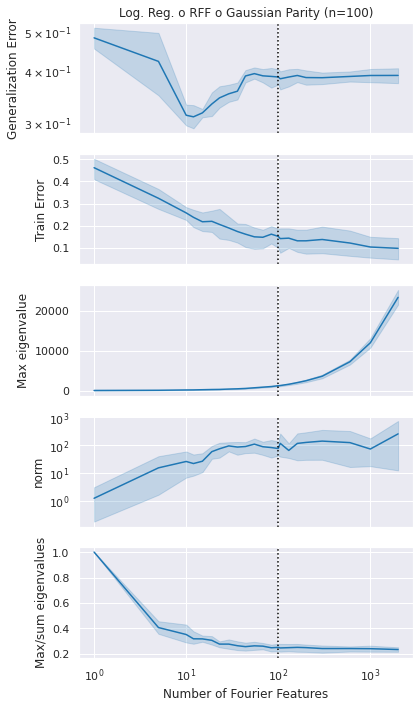

In [39]:
sns.set_style('darkgrid')
sns.set_context('notebook')

metrics = ['Generalization Error', 'Train Error', 'Max eigenvalue', 'norm', 'Max/sum eigenvalues']
f, axes = plt.subplots(len(metrics), 1, figsize=(6, 2*len(metrics)), sharex=True)
for ax, y_label in zip(axes, metrics):
    sns.lineplot(data=df, x='Number of Fourier Features', y=y_label, ax=ax)#, ci=None)
    ax.axvline(n, ls=':', c='black')

axes[0].set_yscale('log')
axes[3].set_yscale('log')
axes[-1].set_xscale('log')
# ax.figure.legend()
axes[0].set_title(f'Log. Reg. o RFF o Gaussian Parity (n={n})')

plt.tight_layout()
# plt.savefig('./figures/ols_vs_ridge_double_descent.pdf')
plt.show()

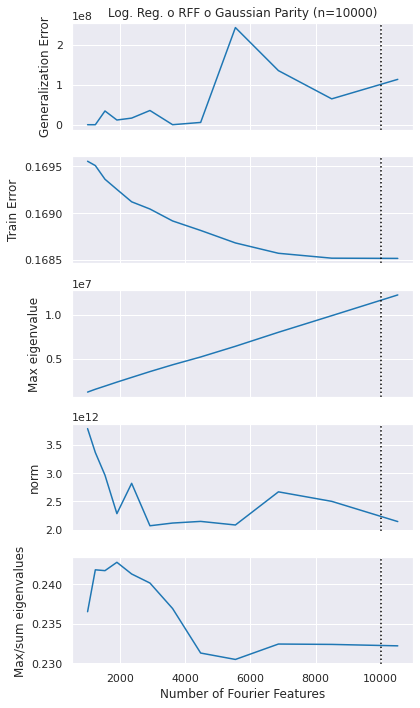

In [7]:
sns.set_style('darkgrid')
sns.set_context('notebook')

metrics = ['Generalization Error', 'Train Error', 'Max eigenvalue', 'norm', 'Max/sum eigenvalues']
f, axes = plt.subplots(len(metrics), 1, figsize=(6, 2*len(metrics)), sharex=True)
for ax, y_label in zip(axes, metrics):
    sns.lineplot(data=df, x='Number of Fourier Features', y=y_label, ax=ax, ci=None)
    ax.axvline(n, ls=':', c='black')
    # ax.set_yscale('log')

# ax.figure.legend()
axes[0].set_title(f'Log. Reg. o RFF o Gaussian Parity (n={n})')

plt.tight_layout()
# plt.savefig('./figures/ols_vs_ridge_double_descent.pdf')
plt.show()

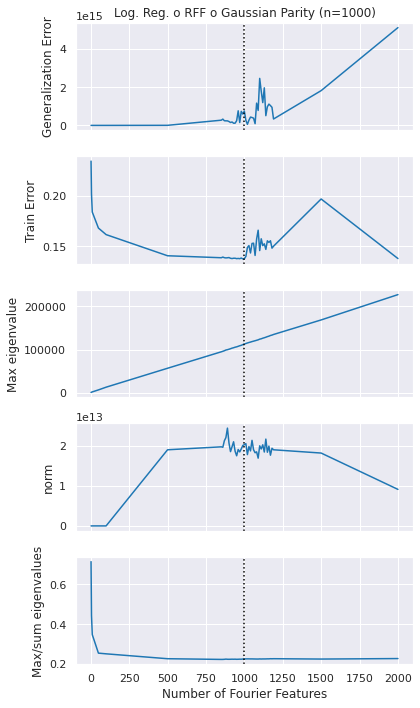

In [153]:
sns.set_style('darkgrid')
sns.set_context('notebook')

metrics = ['Generalization Error', 'Train Error', 'Max eigenvalue', 'norm', 'Max/sum eigenvalues']
f, axes = plt.subplots(len(metrics), 1, figsize=(6, 2*len(metrics)), sharex=True)
for ax, y_label in zip(axes, metrics):
    sns.lineplot(data=df, x='Number of Fourier Features', y=y_label, ax=ax, ci=None)
    ax.axvline(n, ls=':', c='black')
    # ax.set_yscale('log')

# ax.figure.legend()
axes[0].set_title(f'Log. Reg. o RFF o Gaussian Parity (n={n})')

plt.tight_layout()
# plt.savefig('./figures/ols_vs_ridge_double_descent.pdf')
plt.show()

## openml MNIST

In [4]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import check_random_state

In [5]:
X_mnist, y_mnist = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

In [6]:
random_state = check_random_state(0)
permutation = random_state.permutation(X_mnist.shape[0])
X_mnist = X_mnist[permutation]
y_mnist = y_mnist[permutation]
X_mnist = X_mnist.reshape((X_mnist.shape[0], -1))

In [7]:
n = 1000

y_onehot = np.zeros((y_mnist.shape[0], len(np.unique(y_mnist))))
y_onehot[np.arange(len(y_onehot)), np.unique(y_mnist, return_inverse=True)[1]] = 1

X_train, X_test, y_train, y_test = train_test_split(
    X_mnist, y_onehot, train_size=n, test_size=10000)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
fall = np.logspace(np.log10(n), np.log10(1.5*n), 5).astype(int)
rise = -np.logspace(np.log10(n), np.log10(1.5*n), 5).astype(int) + 2*n
start = np.logspace(0, np.log10(0.5 * n), 10).astype(int)
ds = np.unique(np.concatenate([start, rise, fall, [5*n]]))

df_mat_mnist = []

n_reps = 1

for i in range(n_reps):
    rff = RFFTransformer(ds[-1], sigma=1/5, seed=i, relu=True).fit(X_train)
    X_train_rff = rff.transform(X_train)
    X_test_rff = rff.transform(X_test)

    for p in ds:
        # _, singular_values, _ = svd(X_train[:, :p])
        unique_vals, unique_idx = np.unique((X_train_rff[:, :p] > 0).astype(int), axis=0, return_inverse=True)
        internal_rep_mat = np.zeros((len(unique_idx), len(unique_vals)))
        internal_rep_mat[np.arange(len(unique_idx)), unique_idx] = 1
        _, singular_values, _ = svd(internal_rep_mat)

        singular_values = np.sort(singular_values)[::-1]
        s = np.sort(singular_values**2)[::-1]
        max_eval = s[0]
        sum_eval = np.sum(s)
        kf_norms = [np.sum(singular_values[:i+1]) for i in range(10)]
        schatten_norms = [np.sum(singular_values**i)**(1/i) for i in range(1,10+1)]
        
        # lr = LogisticRegression(penalty='none', n_jobs=-2)
        # metric = zero_one_loss
        lr = LinearRegression(n_jobs=-2)
        metric = mean_squared_error

        lr = lr.fit(X_train_rff[:, :p], y_train)
        coef_norm = np.linalg.norm(lr.coef_, axis=1).mean()
        train_error = metric(y_train, lr.predict(X_train_rff[:, :p]))
        test_error = metric(y_test, lr.predict(X_test_rff[:, :p]))

        df_mat_mnist.append([p, train_error, test_error, max_eval, sum_eval, coef_norm] + kf_norms + schatten_norms)

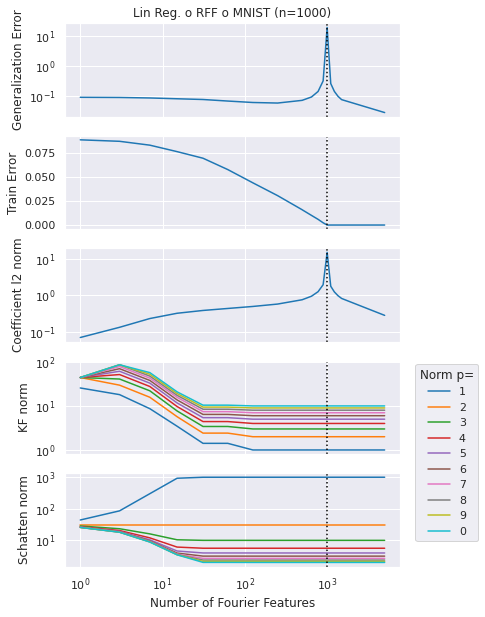

In [13]:
df = pd.DataFrame(
    df_mat_mnist,
    columns=[
        'Number of Fourier Features',
        'Train Error',
        'Generalization Error',
        'Max eigenvalue',
        'Sum of eigenvalues',
        'Coefficient l2 norm',
    ] + [f'KF {i+1}' for i in range(10)] + [f'Schatten {i+1}' for i in range(10)]
)#.melt(var_name='Number of Fourier Features', value_name='Generalization Error')
df['Max/sum eigenvalues'] = df['Max eigenvalue'] / df['Sum of eigenvalues']

sns.set_style('darkgrid')
sns.set_context('notebook')

metrics = ['Generalization Error', 'Train Error', 'Coefficient l2 norm']
f, axes = plt.subplots(len(metrics)+2, 1, figsize=(6, 2*len(metrics)+4), sharex=True)
for ax, y_label in zip(axes, metrics):
    sns.lineplot(data=df, x='Number of Fourier Features', y=y_label, ax=ax, ci=None)
    ax.axvline(n, ls=':', c='black')
    # ax.set_yscale('log')
    
ax = axes[-2]
for metric in [f'KF {i+1}' for i in range(10)]:
    sns.lineplot(data=df, x='Number of Fourier Features', y=metric, ax=ax, label=metric[-1])
ax.set_yscale('log')
ax.set_ylabel('KF norm')
ax.legend(loc='upper left', bbox_to_anchor=(1.03, 1.02), title='Norm p=')
ax.axvline(n, ls=':', c='black')

ax = axes[-1]
for metric in [f'Schatten {i+1}' for i in range(10)]:
    sns.lineplot(data=df, x='Number of Fourier Features', y=metric, ax=ax)#, label=metric[-1])
ax.set_ylabel('Schatten norm')
ax.set_yscale('log')
# ax.legend(loc='upper left', bbox_to_anchor=(1.03, 1.02))
ax.axvline(n, ls=':', c='black')

axes[0].set_yscale('log')
axes[2].set_yscale('log')
axes[-1].set_xscale('log')
# ax.figure.legend()
axes[0].set_title(f'Lin Reg. o RFF o MNIST (n={n})')

# plt.tight_layout()
# plt.savefig('./figures/ols_vs_ridge_double_descent.pdf')
plt.show()

In [42]:
fall = np.logspace(np.log10(n), np.log10(1.5*n), 5).astype(int)
rise = -np.logspace(np.log10(n), np.log10(1.5*n), 5).astype(int) + 2*n
start = np.logspace(0, np.log10(0.5 * n), 10).astype(int)
ds = np.unique(np.concatenate([start, rise, fall, [5*n]]))

df_mat_mnist = []

n_reps = 1

for i in range(n_reps):
    rff = RFFTransformer(max(ds), sigma=1/5, seed=i).fit(X_train)
    X_train_rff = rff.transform(X_train)
    X_test_rff = rff.transform(X_test)

    for p in ds:
        _, singular_values, _ = svd(X_test_rff[:p])
        singular_values = np.sort(singular_values)[::-1]
        s = np.sort(singular_values**2)[::-1]
        max_eval = s[0]
        sum_eval = np.sum(s)
        kf_norms = [np.sum(singular_values[:i+1]) for i in range(10)]
        schatten_norms = [np.sum(singular_values**i)**(1/i) for i in range(1,10+1)]
        
        # lr = LogisticRegression(penalty='none', n_jobs=-2)
        # metric = zero_one_loss
        lr = LinearRegression(n_jobs=-2)
        metric = mean_squared_error

        lr = lr.fit(X_train_rff[:, :p], y_train)
        coef_norm = np.linalg.norm(lr.coef_, axis=1).mean()
        train_error = metric(y_train, lr.predict(X_train_rff[:, :p]))
        test_error = metric(y_test, lr.predict(X_test_rff[:, :p]))

        df_mat_mnist.append([p, train_error, test_error, max_eval, sum_eval, coef_norm] + kf_norms + schatten_norms)

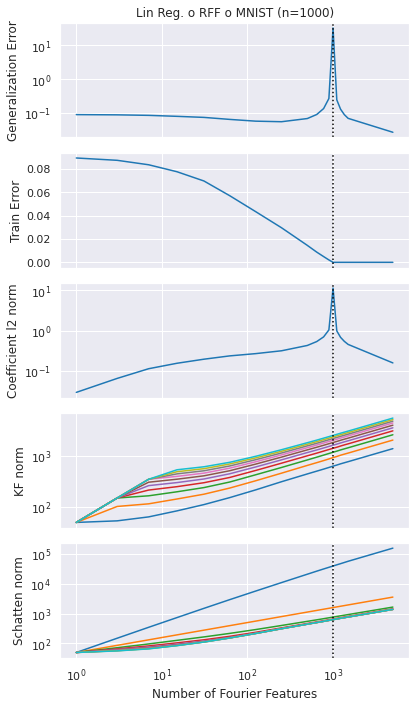

In [43]:
df = pd.DataFrame(
    df_mat_mnist,
    columns=[
        'Number of Fourier Features',
        'Train Error',
        'Generalization Error',
        'Max eigenvalue',
        'Sum of eigenvalues',
        'Coefficient l2 norm',
    ] + [f'KF {i+1}' for i in range(10)] + [f'Schatten {i+1}' for i in range(10)]
)#.melt(var_name='Number of Fourier Features', value_name='Generalization Error')
df['Max/sum eigenvalues'] = df['Max eigenvalue'] / df['Sum of eigenvalues']

sns.set_style('darkgrid')
sns.set_context('notebook')

metrics = ['Generalization Error', 'Train Error', 'Coefficient l2 norm']
f, axes = plt.subplots(len(metrics)+2, 1, figsize=(6, 2*len(metrics)+4), sharex=True)
for ax, y_label in zip(axes, metrics):
    sns.lineplot(data=df, x='Number of Fourier Features', y=y_label, ax=ax, ci=None)
    ax.axvline(n, ls=':', c='black')
    # ax.set_yscale('log')
    
ax = axes[-2]
for metric in [f'KF {i+1}' for i in range(10)]:
    sns.lineplot(data=df, x='Number of Fourier Features', y=metric, ax=ax, ci=None)# , label=metric[-1])
ax.set_yscale('log')
ax.set_ylabel('KF norm')
# ax.legend(loc='upper left', bbox_to_anchor=(1.03, 1.02))
ax.axvline(n, ls=':', c='black')

ax = axes[-1]
for metric in [f'Schatten {i+1}' for i in range(10)]:
    sns.lineplot(data=df, x='Number of Fourier Features', y=metric, ax=ax, ci=None)# , label=metric[-1])
ax.set_ylabel('Schatten norm')
ax.set_yscale('log')
# ax.legend(loc='upper left', bbox_to_anchor=(1.03, 1.02))
ax.axvline(n, ls=':', c='black')

axes[0].set_yscale('log')
axes[2].set_yscale('log')
axes[-1].set_xscale('log')
# ax.figure.legend()
axes[0].set_title(f'Lin Reg. o RFF o MNIST (n={n})')

plt.tight_layout()
# plt.savefig('./figures/ols_vs_ridge_double_descent.pdf')
plt.show()

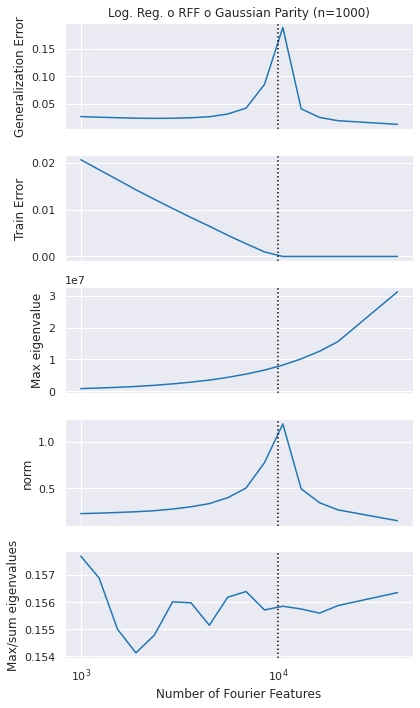

In [274]:
sns.set_style('darkgrid')
sns.set_context('notebook')

metrics = ['Generalization Error', 'Train Error', 'Max eigenvalue', 'norm', 'Max/sum eigenvalues']
f, axes = plt.subplots(len(metrics), 1, figsize=(6, 2*len(metrics)), sharex=True)
for ax, y_label in zip(axes, metrics):
    sns.lineplot(data=df, x='Number of Fourier Features', y=y_label, ax=ax, ci=None)
    ax.axvline(train_samples, ls=':', c='black')
    # ax.set_yscale('log')

axes[-1].set_xscale('log')
# ax.figure.legend()
axes[0].set_title(f'Log. Reg. o RFF o Gaussian Parity (n={n})')

plt.tight_layout()
# plt.savefig('./figures/ols_vs_ridge_double_descent.pdf')
plt.show()

In [133]:
n = 10000

X_train, X_test, y_train, y_test = train_test_split(
    X_mnist, y_mnist, train_size=train_samples, test_size=10000)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [134]:
fall = np.logspace(np.log10(n), np.log10(1.5*n), 5).astype(int)
rise = -np.logspace(np.log10(n), np.log10(1.5*n), 5).astype(int) + 2*n
start = np.logspace(0, np.log10(0.5 * n), 10).astype(int)
ds = np.unique(np.concatenate([start, rise, fall, [2*n]]))
df_mat_mnist = []

n_reps = 1

for i in range(n_reps):
    rff = RFFTransformer(max(ds), sigma=1/5, seed=i).fit(X_train)
    X_train_rff = rff.transform(X_train)
    X_test_rff = rff.transform(X_test)

    for p in ds:
        _, s, _ = svd(X_train_rff[:, :p])
        s = np.sort(s**2)[::-1]
        max_eval = s[0]
        sum_eval = np.sum(s)
        
#         lr = LogisticRegression(penalty='none', n_jobs=-2)
#         metric = zero_one_loss
        lr = LinearRegression(n_jobs=-2)
        metric = mean_squared_error

        lr = lr.fit(X_train_rff[:, :p], y_train)
        coef_norm = np.linalg.norm(lr.coef_, axis=1).mean()
        train_error = metric(y_train, lr.predict(X_train_rff[:, :p]))
        test_error = metric(y_test, lr.predict(X_test_rff[:, :p]))

        df_mat_mnist.append([p, train_error, test_error, max_eval, sum_eval, coef_norm])

In [135]:
df = pd.DataFrame(
    df_mat_mnist,
    columns=[
        'Number of Fourier Features',
        'Train Error',
        'Generalization Error',
        'Max eigenvalue',
        'Sum of eigenvalues',
        'norm',
    ]
)#.melt(var_name='Number of Fourier Features', value_name='Generalization Error')
df['Max/sum eigenvalues'] = df['Max eigenvalue'] / df['Sum of eigenvalues']

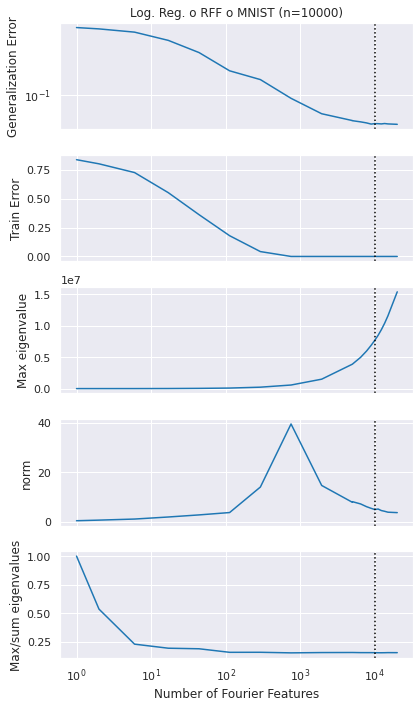

In [140]:
sns.set_style('darkgrid')
sns.set_context('notebook')

metrics = ['Generalization Error', 'Train Error', 'Max eigenvalue', 'norm', 'Max/sum eigenvalues']
f, axes = plt.subplots(len(metrics), 1, figsize=(6, 2*len(metrics)), sharex=True)
for ax, y_label in zip(axes, metrics):
    sns.lineplot(data=df, x='Number of Fourier Features', y=y_label, ax=ax, ci=None)
    ax.axvline(train_samples, ls=':', c='black')
    # ax.set_yscale('log')

axes[0].set_yscale('log')
# axes[1].set_yscale('log')
axes[-1].set_xscale('log')
# ax.figure.legend()
axes[0].set_title(f'Log. Reg. o RFF o MNIST (n={train_samples})')

plt.tight_layout()
# plt.savefig('./figures/ols_vs_ridge_double_descent.pdf')
plt.show()